In [1]:
import src.paths

In [2]:
date = '2022-09-16'

In [3]:
%%time
spikes_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-spikes.pkl')

CPU times: user 17.7 ms, sys: 594 ms, total: 611 ms
Wall time: 6.97 s


In [4]:
%%time
csd_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-csd.pkl')

CPU times: user 29.7 ms, sys: 2.75 s, total: 2.78 s
Wall time: 35.6 s


In [38]:
start = 300 # start time in seconds
end = 1500  # end time in seconds
MAX_THETA = 15 # band max in Hz
MIN_THETA = 2  # band min in Hz
Q = 5
Fs = range(MIN_THETA, MAX_THETA + 1)

In [39]:
def frequency_comb(x, Fs, Q):
    l = []
    for w0 in Fs:
        b, a = scipy.signal.iirnotch(w0, Q, fs=1250)
        y = x - scipy.signal.filtfilt(b, a, x, axis=0)
        l.append(y)
    return np.array(l).T

In [40]:
spikes = spikes_raw.loc[start:end - 1 / 250, 160:163]
csd = csd_raw.loc[start:end - 1 / 1250, 40]

---

In [41]:
x = csd.values * 0.001 # [A/m^3 -> uA / mm^3]

In [42]:
bands = pd.Series(Fs, name='band')
theta = frequency_comb(x, Fs, Q)
theta = {band: y for band, y in zip(bands, theta.T)}
theta = pd.DataFrame(theta, index=csd.index, columns=bands)

In [43]:
hilbert = scipy.signal.hilbert(theta)
phase = np.angle(hilbert)
phase = pd.DataFrame(phase, index=theta.index, columns=theta.columns)

In [44]:
s = (phase / np.pi + 1) / 2

In [58]:
cycle = (s.diff() < -0.5).cumsum()

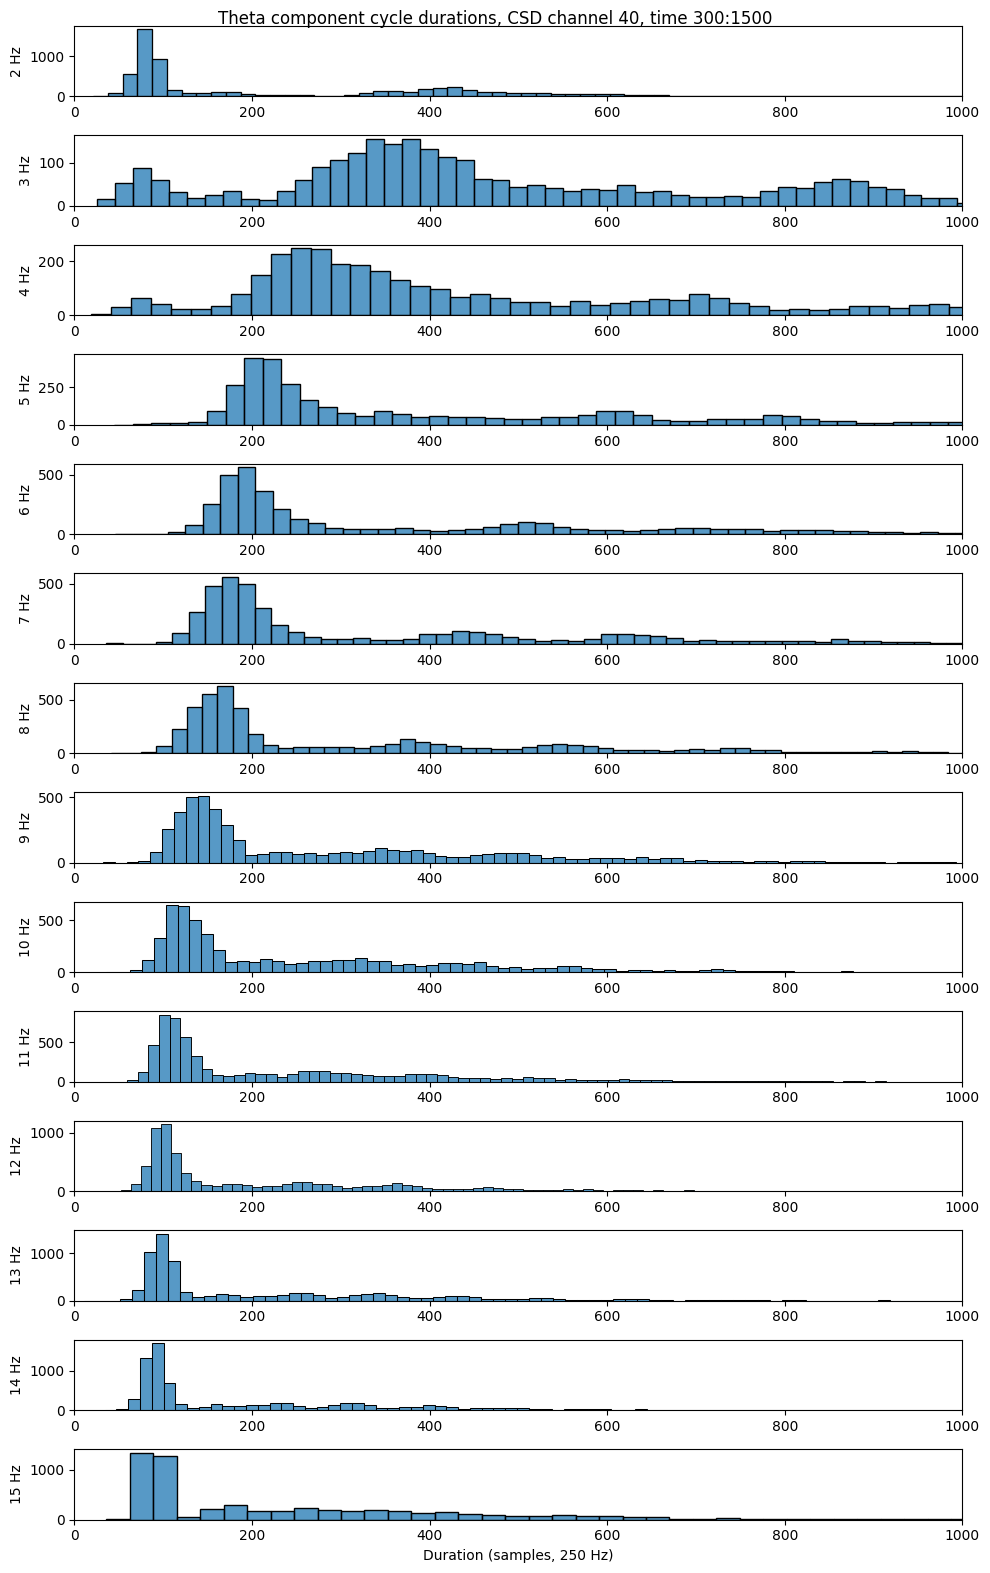

In [62]:
fig, ax = plt.subplots(14, 1, figsize=(10, 16))
plt.suptitle(f'Theta component cycle durations, CSD channel 40, time {start}:{end}')

for i, w0 in enumerate(Fs):
    df = pd.DataFrame({
        'duration': theta[w0].groupby(cycle[w0]).count().astype('int'),
        'minval': theta[w0].groupby(cycle[w0]).min(),
        'maxval': theta[w0].groupby(cycle[w0]).max(),
    })
    
    plt.sca(ax[i])
    plt.xlim([0, 1000])
    sns.histplot(df.duration, bins=100)
    plt.ylabel(f'{w0} Hz')
    if i == len(Fs) - 1:
        plt.xlabel('Duration (samples, 250 Hz)')
    else:
        plt.xlabel('')

plt.tight_layout()
plt.savefig(f'{date}-theta-cycle-durations-time-{start}-{end}.png', dpi=200)
plt.show()